### Pre-talk notes for Speaker!
During talk:
* Minimise file browser
* move to this folder cd .\Documents\GitHub\working-with-twitter-data\HealthDemo
* Zoom in
* Clear cells
* Share public link -> https://github.com/UKDataServiceOpen/working-with-twitter-data/blob/main/HealthDemo/HealthTidyDemo.ipynb
* Share [binder link](https://mybinder.org/v2/gh/UKDataServiceOpen/working-with-twitter-data/HEAD?labpath=%2FHealthDemo%2FHealthTidyDemo.ipynb)

TODO - 22:30 minutes

# Twarc Tidying and Analysis
This notebook covers my initial exploration of 7000 tweets from October 2021 to January 2022, all located in the UK. These tweets were scraped on the 16th Feb 2022 and all contain the keywords:
- cough
- coughing
- sneeze
- sneezing
- fatigue
- headache

Otherwise regarded as common Covid-19 symptoms.
This data was collected using the [HealthTwarcDemo notebook in this repo](https://github.com/UKDataServiceOpen/working-with-twitter-data/HealthDemo/HealthTwarcDemo.ipync)

Throughout this notebook we cover:
- Initial exploration of a dataset from Twitter
- Visualising the increase in term over time
- Investigating connected symptoms with some entry-level Natural language processing
- Building a wordcloud from these words

So let's get started.

In [ ]:
# If running on binder, you will need matplotlib, seaborn, nltk and wordcloud
!pip3 install matplotlib
!pip3 install seaborn
!pip3 install nltk
!pip3 install wordcloud

In [1]:
# Import our pacakges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Change the default style to be bigger, and clearer colored.
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'font.size': 28,
    'figure.figsize':(28,12)
})

# set seaborn style
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.5)

# Create a cool UK Data Service color palette for our plots
colors = ['#E03A6C', '#F5AD42', '#ECE64B', '#449858', '#43A6C6', '#6C2B76']
palette = sns.set_palette(sns.color_palette(colors), n_colors=100)

In case you couldn't successfully scrape any new data in the [HealthTwarcDemo notebook in this repo](https://github.com/UKDataServiceOpen/working-with-twitter-data/HealthDemo/HealthTwarcDemo.ipync) I have included a dataset, [3monthCoughUK.csv](https://github.com/UKDataServiceOpen/working-with-twitter-data/HealthDemo/3monthCoughUK.csv), which you can use.

In [2]:
# Read our data into a dataframe using pandas, convert our dates to datetime objects so our plots can use them!
data = pd.read_csv('3monthCoughUK.csv', parse_dates=['created_at'])

# The head function prints out the first 5 rows.
data.head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,created_at,...,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,__twarc.retrieved_at,__twarc.url,__twarc.version,Unnamed: 73
0,1476704208074289156,1476701470447874050,1.476703e+18,NaN,NaN,181521084,1.226233e+08,NaN,NaN,2021-12-30 23:58:13+00:00,...,"[-1.315192, 53.1109178, -1.229692, 53.148616]",Feature,0f4224b306ddf55e,Sutton in Ashfield,0f4224b306ddf55e,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN
1,1476702886050648077,1476701470447874050,1.476701e+18,NaN,NaN,181521084,1.815211e+08,NaN,NaN,2021-12-30 23:52:58+00:00,...,"[-1.315192, 53.1109178, -1.229692, 53.148616]",Feature,0f4224b306ddf55e,Sutton in Ashfield,0f4224b306ddf55e,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN
2,1476701874116083712,1476686827331461128,1.476687e+18,NaN,NaN,1352804201101991941,6.538482e+07,NaN,NaN,2021-12-30 23:48:57+00:00,...,"[-1.2894037, 52.5436614, -1.2730678, 52.5567908]",Feature,223a7c85e7e3ff1b,Stoney Stanton,223a7c85e7e3ff1b,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN
3,1476697453919408135,1476686090111275009,1.476697e+18,NaN,NaN,1318834717295300609,3.578058e+09,NaN,NaN,2021-12-30 23:31:23+00:00,...,"[0.0748022, 51.4087608, 0.1889376, 51.478931]",Feature,569c1d39d5de5775,Bexley,569c1d39d5de5775,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN
4,1476694735628779526,1476397481869160455,1.476397e+18,NaN,NaN,390000120,3.547992e+09,NaN,NaN,2021-12-30 23:20:35+00:00,...,"[-2.659936, 51.399367, -2.510844, 51.516387]",Feature,7f15dd80ac78ef40,Bristol,7f15dd80ac78ef40,city,2022-02-16T06:36:23+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN


## How to check a Tweet
We can grab the ID from the first column here, and replace the ID in any existing tweet.

For example here is the URL for one of my tweets about this webinar -> https://twitter.com/JosephAllen1234/status/1493911499047419907
That messy number at the end is the Tweet ID. 
https://twitter.com/JosephAllen1234/status/Replace_me_with_a_tweet_ID

So the first row above, has tweet ID - 1476704208074289156

So even pasting the below, will redirect to the correct user.
https://twitter.com/JosephAllen1234/status/1476704208074289156

We should at this redirect see some mention of covid or one of our symptoms. An unfortunate side effect of twitters search is a user called "coughsneeze" may have all their tweets returned in our search too!

In [3]:
data.loc[data['author.username'].str.contains("cough", case=False)]

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,created_at,...,geo.geo.bbox,geo.geo.type,geo.id,geo.name,geo.place_id,geo.place_type,__twarc.retrieved_at,__twarc.url,__twarc.version,Unnamed: 73
3703,1460892050879127552,1460887751541366784,1.460891e+18,NaN,NaN,780168607,58770687.0,NaN,NaN,2021-11-17 08:46:21+00:00,...,"[-2.6750176, 49.4099687, -2.1589927, 49.7327633]",Feature,8fff7619df46bfea,Bailiwick of Guernsey,8fff7619df46bfea,admin,2022-02-16T06:37:45+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN


## Checking some Tweet text
So we've got our data read in successfully, let's print out some of the tweet text to make sure they have something to do with veganism.

In [4]:
# print out the first 5 tweets text for visual inspection
for index in [1,2,3,4,5]:
    print(data['text'][index])
    print('\n')


I sneeze a lot in general sometimes for no apparent reason.


@darrenmark69 Is sneezing the difference? Don't ever remember that being listed as a symptom for coN vid (not that I believe anything they say about it anyway)


@petewall41 A week!!! Ffs. I had the shivers bad yesterday evening, cold one minute and hot the next. Bad fatigue, weakness, stiff muscles. It's been loads of fun 🤦‍♂️


@waywardscots Definitely over 40, and had all those side effects since mine, yesterday morning. Working from home, and had to lie down for a couple of hours this afternoon because I didn't even have the strength to lift my arms to type. Joints aching, full body shivers and a horrific headache.


@ItsMeNatashaP She reckons she's coming to the end of it as she's been coughing for a few days. I done a test earlier and was negative. Never say never though 😂




In [6]:
# I always recommend running info() for basic type information.
# Here we are looking for any weird types, or largely missing values
# data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7097 entries, 0 to 7096
Data columns (total 74 columns):
 #   Column                                 Non-Null Count  Dtype              
---  ------                                 --------------  -----              
 0   id                                     7097 non-null   int64              
 1   conversation_id                        7097 non-null   int64              
 2   referenced_tweets.replied_to.id        3692 non-null   float64            
 3   referenced_tweets.retweeted.id         0 non-null      float64            
 4   referenced_tweets.quoted.id            369 non-null    float64            
 5   author_id                              7097 non-null   int64              
 6   in_reply_to_user_id                    3794 non-null   float64            
 7   retweeted_user_id                      0 non-null      float64            
 8   quoted_user_id                         369 non-null    float64            
 9   created_

In [7]:
# and decribe() for statistical info.
# data.describe()
# Or to supress scientific notation
data[['author.public_metrics.followers_count','public_metrics.like_count','public_metrics.retweet_count']].describe().apply(lambda s: s.apply('{0:.0f}'.format))

,author.public_metrics.followers_count,public_metrics.like_count,public_metrics.retweet_count
count,7097,7097,7097
mean,2560,6,0
std,7492,110,6
min,0,0,0
25%,384,0,0
50%,951,1,0
75%,2381,3,0
max,236203,8653,298


At this point I am thinking we have too many columns to analyse really. It's worth at this point asking if there is anything we could remove now. Though if we are exploring this may be premature.

There is far too much to analyze here, considering what I am here to look for really the text is the main thing I care about. You may wish to retain the author ID if you want to track somebody who reports symptoms over time for example.

I am going to keep the following:
* id - The Tweet ID
* created_at - The time the tweet was created
* text - the text that makes up a tweet
* author.id - the author ID
* author.created_at - when the users account was created
* author.username - the Twitter users username
* author.location - a self-defined location
* author.public_metrics.followers_count - Number of followers a user has
* geo.full_name - the full name describing a tweets geolocation
* public_metrics.like_count - number of likes on this tweet
* public_metrics.retweet_count - number of retweets on this tweer.

In [ ]:
data = data[['id','created_at', 'text','author.id','author.created_at', 'author.username','author.location','author.public_metrics.followers_count','geo.full_name','public_metrics.like_count','public_metrics.retweet_count']]
data.head()

# Have covid-19 symptoms grown?
Let's start by checking if there is evidence in these tweets that COVID has grown in the UK over this period.

Those of us still checking the news will know that in late November we had the Omicron strain develop. I have included a dataset "covid_data" which contains new case numbers in the UK from https://ourworldindata.org/explorers/coronavirus-data-explorer

In [8]:
# read in official covid data, convert dates
covid = pd.read_csv('covid_data.csv', parse_dates=['date'])

# Set the date as our index so our plotting libraries format them
covid = covid.set_index('date')

[Text(0.5, 1.0, 'Number of covid cases over time')]

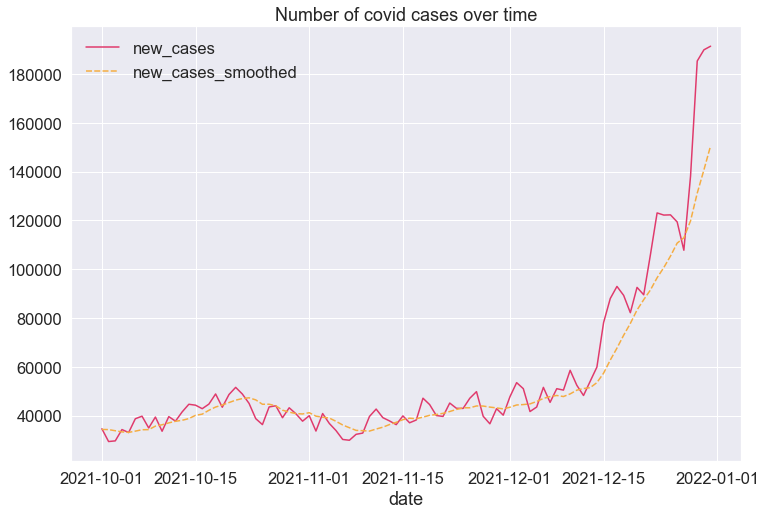

In [9]:
sns.lineplot(data=covid).set(title='Number of covid cases over time')

A very upsetting and familiar winter graph for Covid-19. But is it replicated in our very small Twitter dataset?

[Text(0.5, 1.0, 'Number of tweets containing covid symptoms in UK over time')]

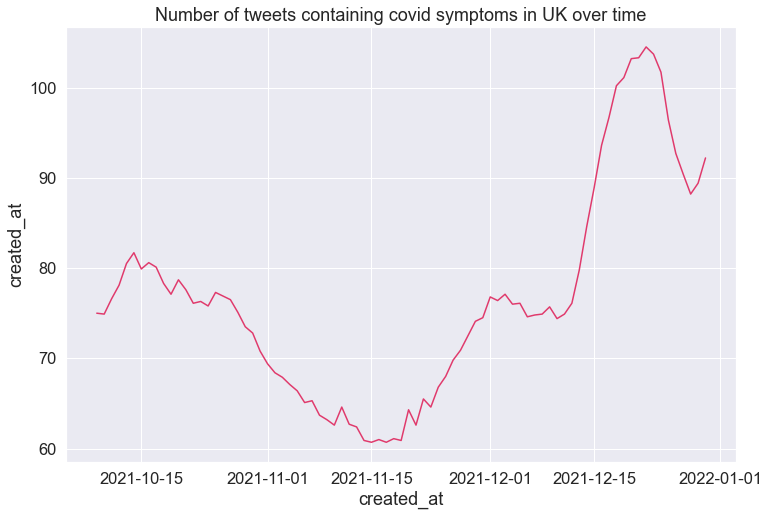

In [10]:
sns.lineplot(data=data['created_at'].groupby(data.created_at.dt.date).count().rolling(10).mean()).set(title='Number of tweets containing covid symptoms in UK over time')

Sort of, there seemed to be larger reporting of covid symptoms back in October that have not that wasn't represented with more cases.
Do the Tweets reflect covid numbers, covid paranoia or both?

There is no doubt there is a correlation between these datasets, but at this point we can't really tell why this happens. Social media is infamous for "look at me" behavior which adds a huge bias here.

# Symtoms over time

We can go a step further though, we could for example try to break down counts per day for tweets which contain our named symptoms. This could help us seperate out omicron hype from the delta hype. Omicron sufferers generally seem to have more of a sneeze and headache illness than the coughs we previously assocaited with covid-19. We can try to visualize this too.

In [11]:
# Build columns to flag whether text contains our keywords
data['has_cough'] = data.text.str.contains('cough') | data.text.str.contains('coughing')
data['has_sneeze'] = data.text.str.contains('sneeze') | data.text.str.contains('sneezing')
data['has_fatigue'] = data.text.str.contains('fatigue')
data['has_headache'] = data.text.str.contains('headache')

# fatigue, sneeze, sneezing, headache
data[['has_cough','has_sneeze','has_fatigue','has_headache']].describe()

,has_cough,has_sneeze,has_fatigue,has_headache
count,7097,7097,7097,7097
unique,2,2,2,2
top,True,False,False,False
freq,3560,6430,6341,5082


In [12]:
# Log out some tweets that should contain coughs
for index in [1,2,3]:
    print(data[data.has_cough == True].reset_index()['text'][index])
    print('\n')

Missus tested positive for Covid today, she feels totally fine and the only reason she tested was cos she had a cough. I had my booster yesterday morning and since 4pm yesterday I've felt absolutely dreadful. How absurd is it that she has the virus but feels better than me? 🤦‍♂️


@BrandonButch I have had a cough for around 4 weeks- went to take PCR where I live and came back negative.


@KristyLKnapp Thanks lovely. Feeling okay. Just a cough, maybe a bit of a fever tonight. Im only 12 hours in.




In [13]:
# Log out some tweets that should contain sneezes
for index in [1,2,3]:
    print(data[data.has_sneeze == True].reset_index()['text'][index])
    print('\n')

I sneeze a lot in general sometimes for no apparent reason.


@darrenmark69 Is sneezing the difference? Don't ever remember that being listed as a symptom for coN vid (not that I believe anything they say about it anyway)


@vinniephilpott @jtomsett93 big sneeze maybe




In [14]:
# Log out some tweets that should contain fatigue
for index in [1,2,3]:
    print(data[data.has_fatigue == True].reset_index()['text'][index])
    print('\n')

@CabbyDes It's been terrible mate. Fever, shaking, fatigue, swelling under armpit, heart pounding. Was quite scary at one point mate. Starting to feel bit better now


@ProperCabby I was shaking uncontrollably with fever, feeling cold then hot, heart started pounding at one point, whole body was stiff, fatigue, even struggled to get out the bath earlier. It really was awful mate. Starting to feel a little more normal now, hoping to get out in cab tomorrow


Now Brendan Rodgers has jumped on the players welfare/ fatigue bandwagon! Wonder how many games some Celtic players were playing when they won everything under him ! Can’t remember him saying anything then 🤷🏽




In [15]:
# Log out some tweets that should contain headache
for index in [1,2,3]:
    print(data[data.has_headache == True].reset_index()['text'][index])
    print('\n')

@mrmterry I suffered from pressure headaches for ages, got to the point where I waking up with a headache, going to sleep with a headache, got really depressed. Tried an over the counter Sudafed tablet(s) from my chemist, took a day or so but it worked!


@mrmterry Pressure headache?


Day 3 #COVID19. slept,slept,slept headache gone, aches and pains gone, cough gone...just exhausted. Mrs M the better patient still nausea and exhausted.  over the worst! #Covid #coronavirus




<AxesSubplot:title={'center':'Mentions of headache'}, xlabel='created_at', ylabel='has_headache'>

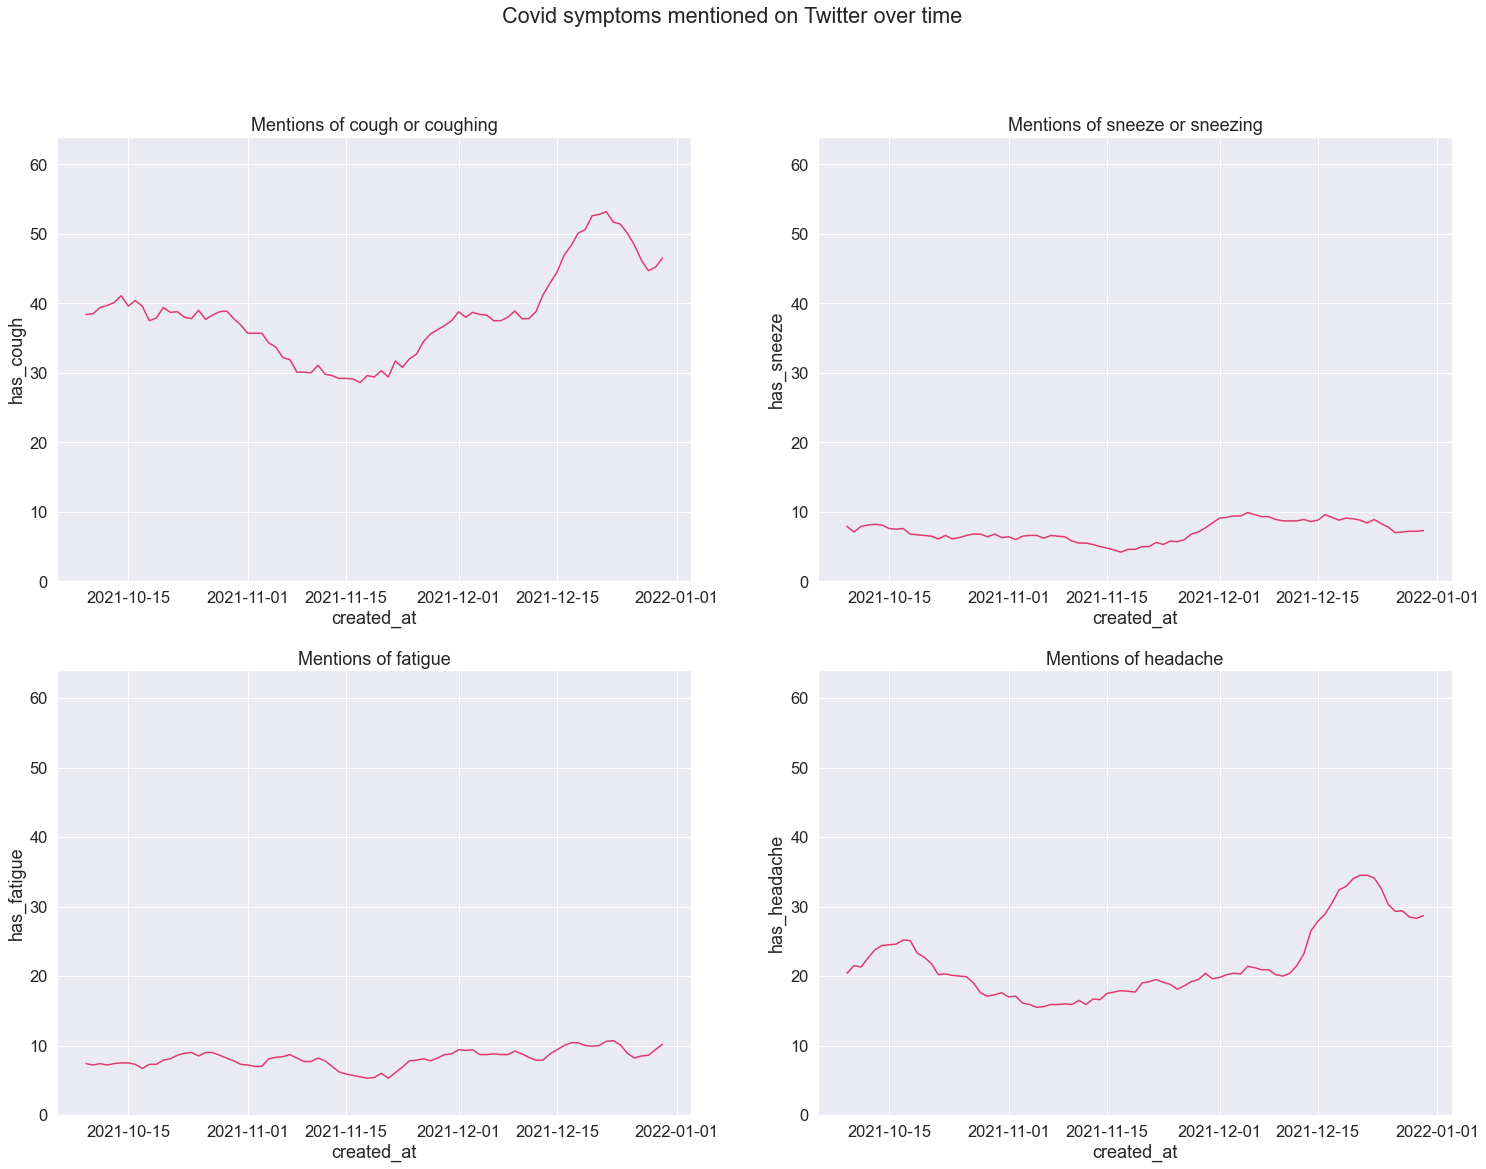

In [16]:
# create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(25, 18))
max = data.groupby(data.created_at.dt.date).has_cough.sum().max()

# set datasets for each plot
axes[0,0].set_ylim(0, max)
axes[0,0].set_title('Mentions of cough or coughing')
axes[0,1].set_ylim(0, max)
axes[0,1].set_title('Mentions of sneeze or sneezing')
axes[1,0].set_ylim(0, max)
axes[1,0].set_title('Mentions of fatigue')
axes[1,1].set_ylim(0, max)
axes[1,1].set_title('Mentions of headache')

# set big title
fig.suptitle('Covid symptoms mentioned on Twitter over time')

# create lineplots
sns.lineplot(ax=axes[0, 0], data=data.groupby(data.created_at.dt.date).has_cough.sum().rolling(10).mean())
sns.lineplot(ax=axes[0, 1],  data=data.groupby(data.created_at.dt.date).has_sneeze.sum().rolling(10).mean())
sns.lineplot(ax=axes[1, 0], data=data.groupby(data.created_at.dt.date).has_fatigue.sum().rolling(10).mean())
sns.lineplot(ax=axes[1, 1],  data=data.groupby(data.created_at.dt.date).has_headache.sum().rolling(10).mean())

So we can see that there seems to be a baseline of fatigue and sneezing that aren't really growing with covid cases.

On the other hand coughing and headaches appear at a higher frequency, and also seem to surge just before the number of covid cases do.

# Have we missed a symptom?

My next hunch comes from a tweet like these:
"Fever, shaking, fatigue, swelling under armpit, heart pounding. Was quite scary at one point mate. Starting to feel bit better now"
"slept,slept,slept headache gone, aches and pains gone, cough gone"

Users seem to be reporting symptoms I wasn't looking for like:
- sleeping
- heart pounding
- shaking
- swelling

To find these, it might be worth looking for words which appear with our terms. To begin lets simply take a word frequency count.

In [17]:
# import our NLP library
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
# split text by whitespace
# drop any empty rows before tokenize
# data['text'] = data['text'].dropna()
wordlist = data['text'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)
word_dist = nltk.FreqDist(words)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])

In [19]:
# What are our top 10 words?
wordCount.head(10)

,Word,Frequency
0,.,8262
1,@,6636
2,a,6031
3,",",6029
4,I,5768
5,the,4841
6,and,4375
7,to,3937
8,’,2988
9,cough,2687


Our most common words largely contain punctuation and what are called in NLP "stop words", these are words that traditionally add no context to a sentence like I, you, a, the, but etc.

In [20]:
# split text by whitespace
# drop any empty rows before tokenize
# data['text'] = data['text'].dropna()
wordlist = data['text'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)

# remove non alphanumeric characters
new_words= [word for word in words if word.isalnum()]

word_dist = nltk.FreqDist(new_words)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])

In [21]:
# What are our top ten words, without non alphanumeric cahracters
wordCount.head(10)

,Word,Frequency
0,a,6031
1,I,5768
2,the,4841
3,and,4375
4,to,3937
5,cough,2687
6,of,2539
7,it,2180
8,in,1971
9,headache,1937


Punctuation is gone, now let's remove "stopwords". NLTK actually has a list of these

In [22]:
# stopwords are the words that add 'nothing' to a sentence, let's remove them. NLTK can help here.
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# import and print stop words for demos sake
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
# split text by whitespace
# drop any empty rows before tokenize
# data['text'] = data['text'].dropna()
wordlist = data['text'].str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)

# remove non alphanumeric characters
new_words= [word for word in words if word.isalnum()]

# remove stop words
stop_words = set(stopwords.words('english'))
filtered_new_words = [w for w in new_words if not w.lower() in stop_words]

word_dist = nltk.FreqDist(filtered_new_words)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])



In [25]:
# Log words without stop words
wordCount.head(10)

,Word,Frequency
0,cough,2687
1,headache,1937
2,https,1365
3,coughing,1083
4,amp,859
5,like,727
6,fatigue,721
7,got,651
8,cold,576
9,get,560


We don't have all of them here, but we do have a lot of them. I in particular has been skipped because we haven't lowercased all our words when we tokenize them.

In [26]:
# split text by whitespace
# we add in a lower() function
wordlist = data['text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)

# remove non alphanumeric characters
new_words= [word for word in words if word.isalnum()]

# remove stop words
stop_words = set(stopwords.words('english'))
filtered_new_words = [w for w in new_words if not w.lower() in stop_words]

word_dist = nltk.FreqDist(filtered_new_words)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])



In [27]:
# lowercase all words, to merge Cough and cough for example.
wordCount.head(10)

,Word,Frequency
0,cough,2919
1,headache,2092
2,https,1365
3,coughing,1141
4,amp,859
5,covid,849
6,fatigue,789
7,like,746
8,got,723
9,cold,624


finally we are likely underreporting any word here that can be conjugated.
Think words like:
- swim
- swam
- swimming

all refer to the "stem" swim. We will experience this with:
- cough
- coughed
- coughing

So it's worth merging these.

In [29]:
# steam all words where possible
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [30]:
# split text by whitespace
# we add in a lower() function
wordlist = data['text'].str.lower().str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(wordlist)

# remove non alphanumeric characters
new_words= [word for word in words if word.isalnum()]

# remove stop words
stop_words = set(stopwords.words('english'))
filtered_new_words = [w for w in new_words if not w.lower() in stop_words]
stems = [ps.stem(word) for word in filtered_new_words if word.isalnum()]

word_dist = nltk.FreqDist(stems)
wordCount = pd.DataFrame(word_dist.most_common(),
                    columns=['Word', 'Frequency'])



In [31]:
# demo stemming of fatigued
ps.stem('fatigued')

'fatigu'

In [32]:
# show top 50 occuring stems
wordCount.head(50)

,Word,Frequency
0,cough,4096
1,headach,2158
2,http,1365
3,day,1018
4,feel,879
5,get,874
6,amp,859
7,covid,852
8,fatigu,801
9,like,772


We can see some web language leaking in now:
- http is the protocol used to request assets on the web
- amp is a special character code.

In [33]:
# remove web terminology
wordCount = wordCount[wordCount.Word != 'http']
wordCount = wordCount[wordCount.Word != 'amp']

<AxesSubplot:xlabel='Frequency', ylabel='Word'>

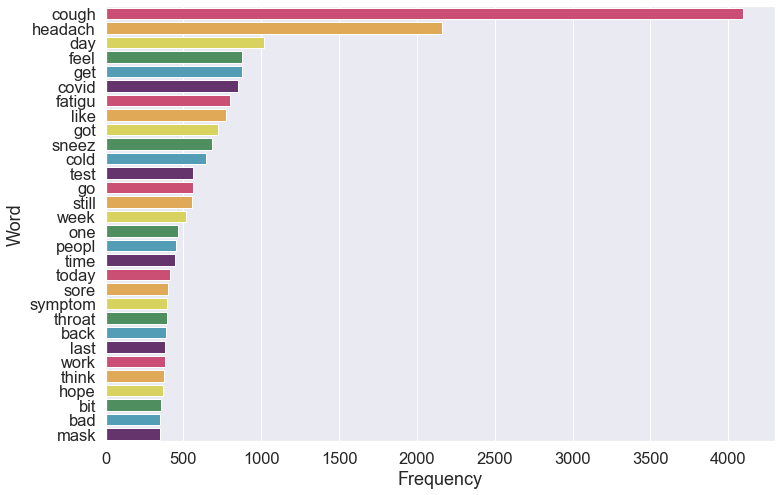

In [34]:
sns.barplot(data=wordCount.head(20), y= wordCount.head(30).Word, x = wordCount.head(30).Frequency)

In this alone we can see some common terms:
- cold
- sore
- throat
- back

# Wordclouds
Looking at this list is great, but a wordcloud is always a fun, and easy addition once you are at this point!
We can use our wordCount object to build the format it wants.


In [38]:
# prepare format wordcloud pacakge expects
bag = wordCount[['Word','Frequency']]
bag.col = ['words','counts']

d = {}
for a, x in bag.values:
    d[a] = x
    
# d.head

C:\Users\Joe\AppData\Local\Temp/ipykernel_7112/4000980849.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  bag.col = ['words','counts']


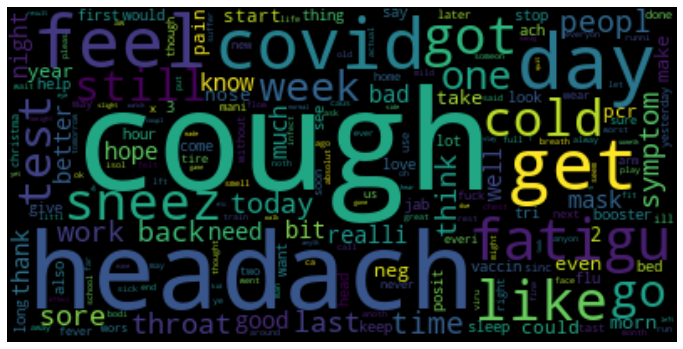

In [39]:
from wordcloud import WordCloud
from PIL import Image

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

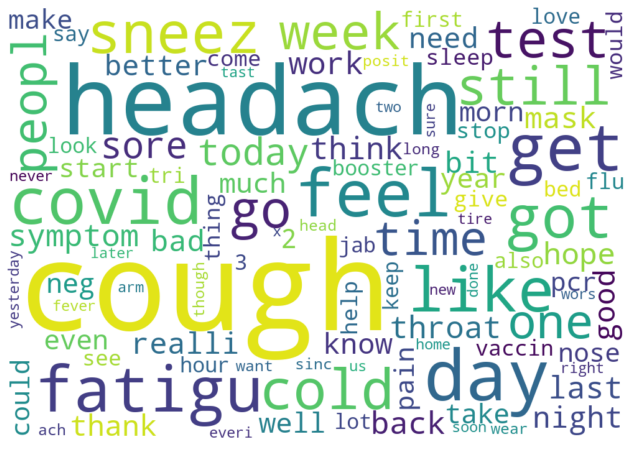

In [40]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(width=1000, height= 700, max_font_size=200, max_words=100, background_color="white").generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

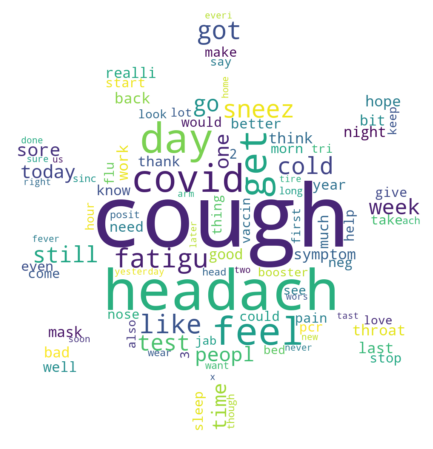

In [41]:
covid_mask = np.array(Image.open("mask.png"))

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(width=1000, height= 700, max_font_size=500, max_words=100, background_color="white", mask=covid_mask).generate_from_frequencies(d)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Most liked content
We have access to likes and retweets, let's check out what the most liked content is.

In [42]:
# And how about the most liked tweet?
data.sort_values(by='public_metrics.like_count', ascending=False).head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,created_at,...,geo.place_id,geo.place_type,__twarc.retrieved_at,__twarc.url,__twarc.version,Unnamed: 73,has_cough,has_sneeze,has_fatigue,has_headache
1496,1471135074955501572,1471135074955501572,NaN,NaN,NaN,1404545231777841152,NaN,NaN,NaN,2021-12-15 15:08:28+00:00,...,38d67cacb385e69d,city,2022-02-16T06:36:55+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,False,False,False,True
750,1473731064459841547,1473728367295934475,1.473728e+18,NaN,NaN,285794441,5.744141e+07,NaN,NaN,2021-12-22 19:04:01+00:00,...,5c6453db6560163a,city,2022-02-16T06:36:37+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,True,False,False,False
1919,1469641709722210312,1469631923639173120,1.469633e+18,NaN,NaN,3996146667,1.255896e+18,NaN,NaN,2021-12-11 12:14:22+00:00,...,37aa02b9b040fa60,city,2022-02-16T06:37:04+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,False,False,True,False
2100,1468860790056931329,1468860790056931329,NaN,NaN,NaN,62595328,NaN,NaN,NaN,2021-12-09 08:31:17+00:00,...,21a9d859b598883a,city,2022-02-16T06:37:08+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,True,False,False,False
4846,1454205471053828100,1454205471053828100,NaN,NaN,1.453767e+18,65062333,NaN,NaN,1.004856e+18,2021-10-29 21:56:16+00:00,...,315b740b108481f6,city,2022-02-16T06:38:09+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,True,False,False,False


In [43]:
mostLikedIndex = 1496
print(data['id'][mostLikedIndex])
print(data['text'][mostLikedIndex])

1471135074955501572
Someone in my group chat just said Only variant I'll be getting this weekend is the drinking beer variant main symptoms are drinking beer then headache the next day lol quality


In [44]:
# And how about the most retweeted?
data.sort_values(by='public_metrics.retweet_count', ascending=False).head()

,id,conversation_id,referenced_tweets.replied_to.id,referenced_tweets.retweeted.id,referenced_tweets.quoted.id,author_id,in_reply_to_user_id,retweeted_user_id,quoted_user_id,created_at,...,geo.place_id,geo.place_type,__twarc.retrieved_at,__twarc.url,__twarc.version,Unnamed: 73,has_cough,has_sneeze,has_fatigue,has_headache
1496,1471135074955501572,1471135074955501572,NaN,NaN,NaN,1404545231777841152,NaN,NaN,NaN,2021-12-15 15:08:28+00:00,...,38d67cacb385e69d,city,2022-02-16T06:36:55+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,False,False,False,True
1919,1469641709722210312,1469631923639173120,1.469633e+18,NaN,NaN,3996146667,1.255896e+18,NaN,NaN,2021-12-11 12:14:22+00:00,...,37aa02b9b040fa60,city,2022-02-16T06:37:04+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,False,False,True,False
4612,1455557148197392387,1455557148197392387,NaN,NaN,NaN,292400876,NaN,NaN,NaN,2021-11-02 15:27:21+00:00,...,09ba692cbddfc92c,city,2022-02-16T06:38:04+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,False,False,False,False
750,1473731064459841547,1473728367295934475,1.473728e+18,NaN,NaN,285794441,5.744141e+07,NaN,NaN,2021-12-22 19:04:01+00:00,...,5c6453db6560163a,city,2022-02-16T06:36:37+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,True,False,False,False
3141,1463837286211239937,1463837286211239937,NaN,NaN,NaN,1007584914202451968,NaN,NaN,NaN,2021-11-25 11:49:40+00:00,...,0b30aadf406d13cc,city,2022-02-16T06:37:31+00:00,https://api.twitter.com/2/tweets/search/all?ex...,2.9.2,NaN,False,False,True,False


In [45]:
mostRetweetedIndex = 1496
print(data['id'][mostRetweetedIndex])
print(data['text'][mostRetweetedIndex])

1471135074955501572
Someone in my group chat just said Only variant I'll be getting this weekend is the drinking beer variant main symptoms are drinking beer then headache the next day lol quality
